In [53]:
import warnings
warnings.filterwarnings('ignore')
    # Supresses Neural Net Warning "ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached
        # and the optimization hasn't converged yet."
    # Supresses QDA Warning "UserWarning: Variables are collinear"

In [77]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import datetime

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn import tree 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import feature_selection
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.gaussian_process.kernels import RBF
from xgboost import XGBClassifier

In [55]:
# For Numeric and Ordinal values, NOTHING is done, for Categorical values, they are converted to Ordinal values
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html
def preprocessData(dataFrame: pd.DataFrame, columnsToProcess: list) -> np.array:
    tempData = []
    enc = preprocessing.OrdinalEncoder()

    for col in columnsToProcess:
        if (col[1] == 'C'):
            tempDataArray = enc.fit_transform(dataFrame[[col[0]]])
            for i in range(np.shape(tempDataArray)[1]):
                tempData.append(tempDataArray[:, i])
        else:
            tempData.append(dataFrame[col[0]].values)
    
    return np.stack(tempData, axis=1)

In [56]:
#Will ONLY work if the model has a predict function
def getPredictions(model, passengerIDsColumn: pd.Series, dataArrayToPredict: np.array) -> pd.DataFrame:
    results = []
    for i in range(len(dataArrayToPredict)):
        results.append(model.predict([dataArrayToPredict[i,:]])[0])
    return pd.concat([passengerIDsColumn, pd.DataFrame({'Survived' : results})], axis=1)

In [57]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    
    _ = sns.heatmap(
        df.corr(), 
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

In [58]:
trainData = pd.read_csv('./titanic/train.csv',
    usecols=['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
             'Cabin', 'Embarked'],
    dtype={'PassengerId' : int, 'Survived' : int, 'Pclass' : int, 'Name' : str, 'Sex' : str, 'Age' : float,
           'SibSp' : int, 'Parch' : int, 'Ticket' : str, 'Fare' : float, 'Cabin' : str, 'Embarked' : str}
)
testData = pd.read_csv('./titanic/test.csv',
    usecols=['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
    dtype={'PassengerId' : int, 'Pclass' : int, 'Name' : str, 'Sex' : str, 'Age' : float, 'SibSp' : int,
           'Parch' : int, 'Ticket' : str, 'Fare' : float, 'Cabin' : str, 'Embarked' : str}
)

In [59]:
# copy of datasets, originals may be needed for reference
trainCopy = trainData.copy(deep = True)
testCopy = testData.copy(deep = True)
datasets = [trainCopy, testCopy]

In [60]:
# find incomplete columns
print("Sums of incomplete TRAINING values:")
print(datasets[0].isnull().sum())
print("------------------------------")
print("Sums of incomplete TEST values:")
print(datasets[1].isnull().sum())

Sums of incomplete TRAINING values:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
------------------------------
Sums of incomplete TEST values:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [61]:
# since Name is a complete feature, we will use it to engineer the "Title" feature
for dataset in datasets:
    dataset['Title'] = dataset['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]

In [62]:
print("Titles in TRAIN:")
print(datasets[0]['Title'].value_counts())
print("-------------------")
print("Titles in TEST:")
print(datasets[1]['Title'].value_counts())

Titles in TRAIN:
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: Title, dtype: int64
-------------------
Titles in TEST:
Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: Title, dtype: int64


In [63]:
# replace "rare" (fewer than 10 instances) and foreign titles with english equivalent
for dataset in datasets:
    dataset['Title'] = dataset['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    dataset['Title'] = dataset['Title'].replace(['Lady', 'the Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 
                                                'Sir', 'Jonkheer', 'Dona'], 
                                                'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

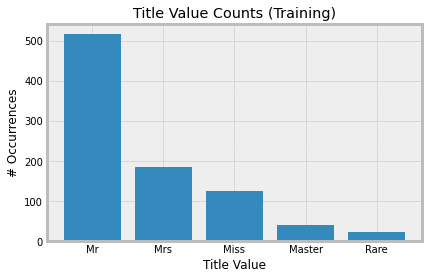

In [82]:
fig, ax = plt.subplots(figsize =(6, 4))
plt.style.use('bmh')
ax.bar(datasets[0]['Title'].unique(),datasets[0]['Title'].value_counts())
plt.title('Title Value Counts (Training)')
plt.ylabel('# Occurrences')
plt.xlabel('Title Value')
plt.show()

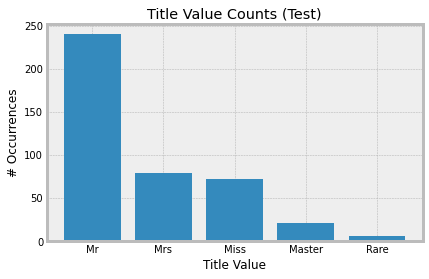

In [83]:
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(datasets[1]['Title'].unique(),datasets[1]['Title'].value_counts())
plt.title('Title Value Counts (Test)')
plt.ylabel('# Occurrences')
plt.xlabel('Title Value')
plt.show()

In [84]:
# now that we have the Title attribute, we will complete the Age feature using the
# median age associated with each title, and complete the rest of the features
for dataset in datasets:
    dataset['Age'] = dataset.groupby('Title', as_index = True)['Age'].apply(lambda age: age.fillna(age.median()))
    dataset['Fare'] = dataset.groupby('Pclass', as_index = True)['Fare'].apply(lambda fare: fare.fillna(fare.median()))
    dataset['Embarked'].fillna(dataset['Embarked'].mode(), inplace = True)

In [85]:
# Feature Engineering
    # FamilySize = siblings + spouse + parents + children
    # AgeClassInteraction = product of age and passenger class
for dataset in datasets:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['AgeClassInteraction'] = dataset['Age'] * dataset['Pclass']

In [133]:
# Discretization and categorical encoding
label = preprocessing.LabelEncoder()
for dataset in datasets:  
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 5)
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int), 7)
    dataset['AgeClassBin'] = pd.cut(dataset['AgeClassInteraction'].astype(int), 10)
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['AgeClassBin_Code'] = label.fit_transform(dataset['AgeClassBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])

In [71]:
# Determine Columns to Use
    # List of columns to use in creating the model and the data type
    #   'C' - Categorical
    #   'N' - Numeric
    #   'O' - Ordinal
colList = [('Pclass', 'O'), ('Sex_Code', 'C'), ('Age', 'N'), ('SibSp', 'N'), ('Parch', 'N'), ('Fare', 'N'),
           ('FamilySize', 'N'), ('AgeClassInteraction', 'N'),
           ('Embarked_Code', 'C'), ('Title_Code', 'C'), ('AgeBin_Code', 'C'),
           ('FareBin_Code', 'C')]


In [74]:
# Preprocess Data
preprocessedDatasets = [preprocessData(dataset, colList) for dataset in datasets]

In [78]:
# Create Model(s) #########################################
    # Inspiration for Classifier Models was taken from the following page
    # https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
classifiers = [
    ("Default Nearest Neighbors", KNeighborsClassifier()),
    ("10 Nearest Neighbors (Brute)", KNeighborsClassifier(n_neighbors=10, algorithm='brute')),
    ("SVM", SVC()),
    ("Gaussian Process", GaussianProcessClassifier()),
    ("Decision Tree", tree.DecisionTreeClassifier()),
    ("Random Forest", RandomForestClassifier()),
    ("Neural Net", MLPClassifier()),
    ("AdaBoost", AdaBoostClassifier()),
    ("Naive Bayes", GaussianNB()),
    ("QDA", QuadraticDiscriminantAnalysis()),
    ("XGB", XGBClassifier())
]

models = []
for i in range(len(classifiers)):
    models.append((classifiers[i][0], classifiers[i][1].fit(preprocessedDatasets[0], datasets[0]['Survived'])))

In [80]:
# Get Predictions
summaryDF = testData[['PassengerId']].copy(deep=True)
resultDFs = [] # List of tuples of Model name, [0], and resulting dataframe (columns PassengerId and Survived), [1]

for model in models:
    resultDFs.append((model[0], getPredictions(model[1], testData['PassengerId'], preprocessedDatasets[1])))
    summaryDF[model[0]] = resultDFs[-1][1]['Survived']

In [ ]:
print(summaryDF.head(10))

In [ ]:
print('Scoring Models:')
results = []
for classifier in classifiers:
    cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .2, train_size = .8, random_state = 0)
    cv_results = model_selection.cross_validate(classifier[1], preprocessedDatasets[0], trainCopy['Survived'],
                    cv  = cv_split, return_estimator=True)
    results.append(cv_results)
    score = cv_results['test_score'].max()
    print('    ' + classifier[0] + ': ' + str(score))

In [ ]:
ada_boost_predictions = results[7]['estimator'][8].fit(preprocessedDatasets[0], trainCopy['Survived']).predict(preprocessedDatasets[0])

In [ ]:
#Plot Accuracy Summary
#Credit: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(trainCopy['Survived'], ada_boost_predictions)
np.set_printoptions(precision=2)

class_names = ['Dead', 'Survived']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, 
                      title='Normalized confusion matrix')

In [ ]:
# Uncomment to save .csv of all results
#summaryDF.to_csv(path_or_buf='modelSummary ' + datetime.datetime.now().strftime("%Y-%m-%d at %H.%M.%S") + '.csv', header=True, index=False, mode='w')

In [ ]:
# Result DataFrame to .csv for Kaggle Submission
# Uncomment and specify classifier number to use to save to .csv
#resultDFs['Insert Classifier Number'][1].to_csv(path_or_buf='kaggle_submission ' + datetime.datetime.now().strftime("%Y-%m-%d at %H.%M.%S") + '.csv', header=True, index=False, mode='w')

In [177]:
target = ['Survived']
x = ['Sex','Pclass', 'Embarked', 'Title','SibSp', 'Parch', 'Age', 'Fare', 'FamilySize']
x_bin = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code', 'AgeClassBin_Code']

In [674]:
# Create Model(s) #########################################
    # Inspiration for Classifier Models was taken from the following page
    # https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
from sklearn import ensemble
from sklearn import linear_model
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import ExtraTreeClassifier
from sklearn import discriminant_analysis
from xgboost import XGBClassifier
classifiers = [
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    GaussianProcessClassifier(),
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    BernoulliNB(),
    GaussianNB(),
    KNeighborsClassifier(),
    SVC(probability=True),
    NuSVC(probability=True),
    LinearSVC(),
    DecisionTreeClassifier(),
    ExtraTreeClassifier(),    
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),
    XGBClassifier()    
]

classifier_cols = ['Name', 'Parameters','Train Accuracy', 'Test Accuracy', 'Time']
classifier_compare = pd.DataFrame(columns = classifier_cols)

predicts = trainCopy[target]

In [675]:
classifier_cols = ['Name', 'Parameters','Train Accuracy', 'Test Accuracy', 'Time']
classifier_compare = pd.DataFrame(columns = classifier_cols)

predicts = trainCopy[target]

i = 0
for classifier in classifiers:

    #set name and parameters
    classifier_name = classifier.__class__.__name__
    classifier_compare.loc[i, 'Name'] = classifier_name
    classifier_compare.loc[i, 'Parameters'] = str(classifier.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(classifier, trainCopy[x_bin], trainCopy[target], cv  = cv_split, return_train_score=True)

    classifier_compare.loc[i, 'Time'] = cv_results['fit_time'].mean()
    classifier_compare.loc[i, 'Train Accuracy'] = cv_results['train_score'].mean()
    classifier_compare.loc[i, 'Test Accuracy'] = cv_results['test_score'].mean()       

    #save MLA predictions - see section 6 for usage
    classifier.fit(trainCopy[x_bin], trainCopy[target])
    predicts[classifier_name] = classifier.predict(trainCopy[x_bin])
    
    i+=1

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
classifier_compare.sort_values(by = ['Test Accuracy'], ascending = False, inplace = True)

In [676]:
classifier_compare

,Name,Parameters,Train Accuracy,Test Accuracy,Time
14,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.832725,0.830726,0.031075
15,NuSVC,"{'break_ties': False, 'cache_size': 200, 'clas...",0.829775,0.828492,0.035938
3,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.858708,0.82514,0.031894
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.819803,0.820112,0.025251
21,XGBClassifier,"{'objective': 'binary:logistic', 'use_label_en...",0.897612,0.820112,0.050021
4,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.902107,0.817877,0.048723
20,QuadraticDiscriminantAnalysis,"{'priors': None, 'reg_param': 0.0, 'store_cova...",0.820927,0.817318,0.001045
17,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.902247,0.81676,0.001005
2,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.902247,0.815642,0.041825
18,ExtraTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.902247,0.813966,0.000756


mean TRAIN score for default tree:  0.902247191011236
mean TEST score for default tree:  0.8184357541899441


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=0.8),
             estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, None],
                         'max_features': [None, 'auto', 'all'],
                         'min_samples_leaf': [1, 5, 10, 0.03, 0.05],
                         'min_samples_split': [2, 5, 10, 0.03, 0.05],
                         'splitter': ['best', 'random']},
             return_train_score=True, scoring='roc_auc')

In [174]:
######## Tuning/Hypertuning Decision Tree Params/Hyperparams #########

cv_split = model_selection.ShuffleSplit(
                                            n_splits = 10, 
                                            test_size = .2, 
                                            train_size = .8, 
                                            random_state = 0
                                       )

# DTC with default params
default_tree = tree.DecisionTreeClassifier(random_state = 0)

initial_results = model_selection.cross_validate(
                                                     default_tree, 
                                                     trainCopy[x_bin], 
                                                     trainCopy[target], 
                                                     cv  = cv_split, 
                                                     return_train_score=True
                                                )
default_tree.fit(trainCopy[x_bin], trainCopy[target])
print('mean TRAIN score for default tree: ', initial_results['train_score'].mean())
print('mean TEST score for default tree: ', initial_results['test_score'].mean())

params = {
            'criterion': ['gini', 'entropy'],
            'splitter': ['best', 'random'],
            'max_depth': [2,4,6,8,10,None],
            'min_samples_split': [2,5,10,.03,.05],
            'min_samples_leaf': [1,5,10,.03,.05],
            'max_features': [None, 'auto', 'all'],
            'random_state': [0]
         }
tuned_tree = model_selection.GridSearchCV(
                                              tree.DecisionTreeClassifier(), 
                                              param_grid=params, 
                                              scoring = 'roc_auc', 
                                              cv = cv_split,
                                              return_train_score=True,
                                         )
tuned_tree.fit(trainCopy[x_bin], trainCopy[target])


print('\nbest params for tuned tree:\n' + 25*'-')
for key, value in tuned_tree.best_params_.items():
    print(key + ': ' + str(value))

# Using recursive feature elimination (RFE) with cross-validation to further refine model
# (from https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV)


# feature selection w cross validation
rfe_tree = feature_selection.RFECV(default_tree, step = 1, cv = cv_split, scoring = 'accuracy')
rfe_tree.fit(trainCopy[x_bin], trainCopy[target])

# new features list
x_rfe = trainCopy[x_bin].columns.values[rfe_tree.get_support()]
rfe_results = model_selection.cross_validate(default_tree, trainCopy[x_rfe], trainCopy[target], cv  = cv_split, return_train_score=True)

# Tune rfe_tree
rfe_tuned = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=params, scoring='roc_auc', cv = cv_split, return_train_score=True)
%time rfe_tuned.fit(trainCopy[x_rfe], trainCopy[target])

print('\nbest params for tuned rfe_tree:\n' + 25*'-')
for key, value in rfe_tuned.best_params_.items():
    print(key + ': ' + str(value))
print(25*'-' + '\n')

print('columns: ', x_rfe)
print('\n\tfeature(s) eliminated:')
flag = False
for i in trainCopy[x_bin].columns.values:
    if (x_rfe.tolist().count(i) == 0):
        flag=True
        print('\t\t', i)
if flag == False:
    print('\t\tNone')
        

mean TRAIN score for default tree:  0.9144662921348313
mean TEST score for default tree:  0.8128491620111733

best params for tuned tree:
-------------------------
criterion: gini
max_depth: None
max_features: None
min_samples_leaf: 10
min_samples_split: 0.05
random_state: 0
splitter: best
CPU times: user 34.6 s, sys: 167 ms, total: 34.8 s
Wall time: 34.8 s

best params for tuned rfe_tree:
-------------------------
criterion: gini
max_depth: 6
max_features: None
min_samples_leaf: 10
min_samples_split: 2
random_state: 0
splitter: best
-------------------------

columns:  ['Sex_Code' 'Pclass' 'Title_Code' 'FamilySize' 'FareBin_Code'
 'AgeClassBin_Code']

	feature(s) eliminated:
		 Embarked_Code
		 AgeBin_Code


In [175]:
# print('mean TRAIN score for default tree: ', initial_results['train_score'].mean())
# print('mean TEST score for default tree: ', initial_results['test_score'].mean())
default_train = ['Default (Train)', initial_results['train_score'].mean()]
default_test = ['Default (Test)', initial_results['test_score'].mean()]
tuned_train = ['Hypertuned (Train)', tuned_tree.cv_results_['mean_train_score'][tuned_tree.best_index_]]
tuned_test = ['Hypertuned (Test)', tuned_tree.cv_results_['mean_test_score'][tuned_tree.best_index_]]
rfe_train = ['RFE (Train)', rfe_tuned.cv_results_['mean_train_score'][rfe_tuned.best_index_]]
rfe_test = ['RFE (Test)', rfe_tuned.cv_results_['mean_test_score'][rfe_tuned.best_index_]]
scores = [default_train, default_test, tuned_train, tuned_test, rfe_train, rfe_test]

In [172]:
scores

[['Default (Train)', 0.902247191011236],
 ['Default (Test)', 0.8184357541899441],
 ['Hypertuned (Train)', 0.8877836968847321],
 ['Hypertuned (Test)', 0.8829916382463429],
 ['RFE (Train)', 0.8877836968847321],
 ['RFE (Test)', 0.8829916382463429]]

In [176]:
scores

[['Default (Train)', 0.9144662921348313],
 ['Default (Test)', 0.8128491620111733],
 ['Hypertuned (Train)', 0.9091520876534934],
 ['Hypertuned (Test)', 0.8901149178262692],
 ['RFE (Train)', 0.9001799613831467],
 ['RFE (Test)', 0.8918789084537833]]

In [156]:
print(35*'-' + ' Before RFE ' + 35*'-')
print('columns: ', trainCopy[x_bin].columns.values)

print(25*'-' + '\n')

print('\nmean TRAIN score: {:.4f}'.format())
print('mean TEST score: {:.4f}'.format(tuned_tree.cv_results_['mean_test_score'][tuned_tree.best_index_]))
print('\n' + 35*'-' + ' After  RFE ' + 35*'-')




print('mean TRAIN score for tuned rfe_tree: {:.4f}'.format(rfe_tuned.cv_results_['mean_train_score'][rfe_tuned.best_index_]))
print('mean TEST score for tuned rfe_tree: {:.4f}'.format(rfe_tuned.cv_results_['mean_test_score'][rfe_tuned.best_index_]))
print('\nDifference of {:.4f} with RFE...'.format(rfe_tuned.cv_results_['mean_test_score'][rfe_tuned.best_index_] - tuned_tree.cv_results_['mean_test_score'][tuned_tree.best_index_]))

----------------------------------- Before RFE -----------------------------------
columns:  ['Sex_Code' 'Pclass' 'Embarked_Code' 'Title_Code' 'FamilySize'
 'AgeBin_Code' 'FareBin_Code']
-------------------------



IndexError: Replacement index 0 out of range for positional args tuple

In [697]:
vote_est = [
    
    ('ada', ensemble.AdaBoostClassifier()),
    ('bc', ensemble.BaggingClassifier()),
    ('etc', ensemble.ExtraTreesClassifier()),
    ('gbc', ensemble.GradientBoostingClassifier()),
    ('rfc', ensemble.RandomForestClassifier()),
    ('gpc', GaussianProcessClassifier()),    
    ('lr', linear_model.LogisticRegressionCV()),    
    ('bnb', BernoulliNB()),
    ('gnb', GaussianNB()),    
    ('knn', KNeighborsClassifier()),    
    ('svc', SVC(probability=True)),   
    ('xgb', XGBClassifier())

]


#Hard Vote or majority rules
hard_voting = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
hard_cv = model_selection.cross_validate(hard_voting, trainCopy[x_bin], trainCopy[target], cv  = cv_split, return_train_score=True)
%time hard_voting.fit(trainCopy[x_bin], trainCopy[target])



#Soft Vote or weighted probabilities
soft_voting = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
soft_cv = model_selection.cross_validate(soft_voting, trainCopy[x_bin], trainCopy[target], cv  = cv_split, return_train_score=True)
%time soft_voting.fit(trainCopy[x_bin], trainCopy[target])


CPU times: user 22.5 s, sys: 4.05 s, total: 26.6 s
Wall time: 3.44 s
CPU times: user 20.7 s, sys: 2.78 s, total: 23.5 s
Wall time: 3.13 s


VotingClassifier(estimators=[('ada', AdaBoostClassifier()),
                             ('bc', BaggingClassifier()),
                             ('etc', ExtraTreesClassifier()),
                             ('gbc', GradientBoostingClassifier()),
                             ('rfc', RandomForestClassifier()),
                             ('gpc', GaussianProcessClassifier()),
                             ('lr', LogisticRegressionCV()),
                             ('bnb', BernoulliNB()), ('gnb', GaussianNB()),
                             ('knn', KNeighborsClassifier()),
                             ('svc', SVC(probability=T...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=Non

In [698]:
print(20*'-' + 'Hard Voting' + 20*'-')
print("Hard Voting Training w/bin score mean: {:.4f}". format(hard_cv['train_score'].mean()*100)) 
print("Hard Voting Test w/bin score mean: {:.4f}". format(hard_cv['test_score'].mean()*100))
print("Hard Voting Test w/bin score 3*std: +/- {:.4f}". format(hard_cv['test_score'].std()*100*3))

print(20*'-' + 'Soft Voting' + 20*'-')
print("Soft Voting Training w/bin score mean: {:.4f}". format(soft_cv['train_score'].mean()*100)) 
print("Soft Voting Test w/bin score mean: {:.4f}". format(soft_cv['test_score'].mean()*100))
print("Soft Voting Test w/bin score 3*std: +/- {:.4f}". format(soft_cv['test_score'].std()*100*3))

--------------------Hard Voting--------------------
Hard Voting Training w/bin score mean: 87.4719
Hard Voting Test w/bin score mean: 81.6760
Hard Voting Test w/bin score 3*std: +/- 6.0799
--------------------Soft Voting--------------------
Soft Voting Training w/bin score mean: 88.2303
Soft Voting Test w/bin score mean: 81.7877
Soft Voting Test w/bin score 3*std: +/- 7.1185


In [692]:
print(10*'-' + 'Hard Voting' + 10*'-')
print("Hard Voting Training w/bin score mean: {:.4f}". format(hard_cv['train_score'].mean()*100)) 
print("Hard Voting Test w/bin score mean: {:.4f}". format(hard_cv['test_score'].mean()*100))
print("Hard Voting Test w/bin score 3*std: +/- {:.4f}". format(hard_cv['test_score'].std()*100*3))

print(10*'-' + 'Soft Voting' + 10*'-')
print("Soft Voting Training w/bin score mean: {:.4f}". format(soft_cv['train_score'].mean()*100)) 
print("Soft Voting Test w/bin score mean: {:.4f}". format(soft_cv['test_score'].mean()*100))
print("Soft Voting Test w/bin score 3*std: +/- {:.4f}". format(soft_cv['test_score'].std()*100*3))

----------Hard Voting----------
Hard Voting Training w/bin score mean: 94.2135
Hard Voting Test w/bin score mean: 83.6313
Hard Voting Test w/bin score 3*std: +/- 6.3178
----------Soft Voting----------
Soft Voting Training w/bin score mean: 94.7612
Soft Voting Test w/bin score mean: 83.9106
Soft Voting Test w/bin score 3*std: +/- 9.0192


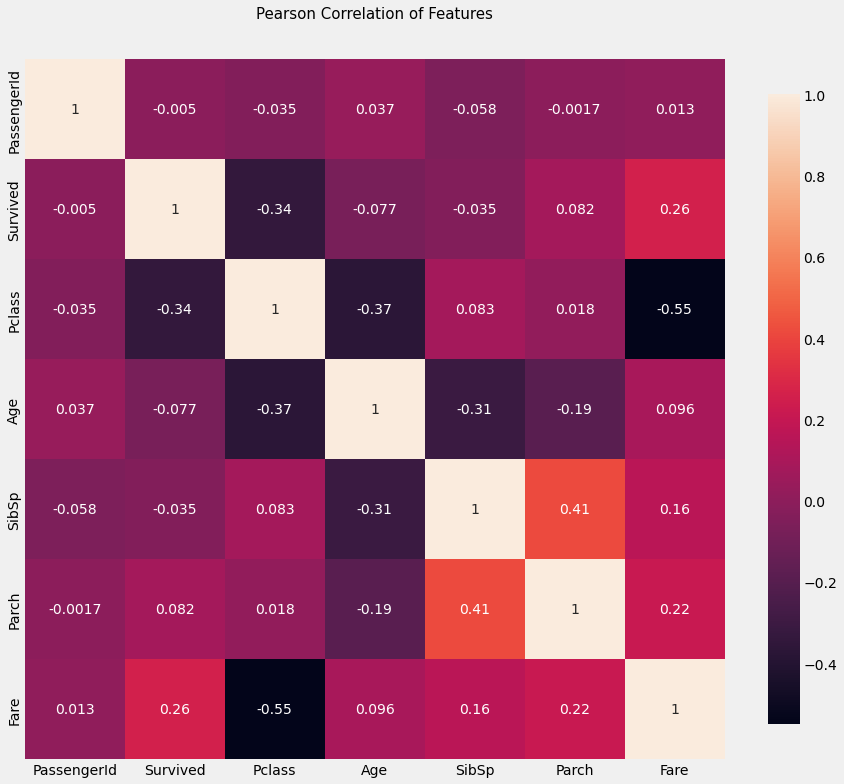

In [52]:
my_cmap = sns.diverging_palette(h_neg=240, h_pos=30,s=99,l=60,sep=7,n=20)
correlation_heatmap(trainCopy)

In [ ]:
plt.figure(figsize=[16,12])

plt.subplot(234)
plt.hist(x = [trainCopy[trainCopy['Survived']==1]['Pclass'], trainCopy[trainCopy['Survived']==0]['Pclass']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Survival by Passenger Class')
plt.xlabel('Pclass')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(235)
plt.hist(x = [trainCopy[trainCopy['Survived']==1]['Age'], trainCopy[trainCopy['Survived']==0]['Age']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Survival by Age')
plt.xlabel('Age (Years)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(236)
plt.hist(x = [trainCopy[trainCopy['Survived']==1]['Sex'], trainCopy[trainCopy['Survived']==0]['Sex']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Survival by Sex')
plt.xlabel('Sex (Male or Female)')
plt.ylabel('# of Passengers')
plt.legend()